# Temperature Time Series Analysis - Johannesburg
## November 3-9, 2021 Daily Temperature Analysis

This notebook provides a comprehensive analysis of temperature data for Johannesburg from November 3-9, 2021. The analysis includes time series visualization, spatial mapping, and statistical summaries.


**Data path:** `Toolathon/Processed Datasets for Examples/Example 4/Heat Point Analysis/IBM_data/code1_data`  

This folder contains **seven files**.  
Please select and upload **all seven files at once** into Colab so that they are correctly placed in the working directory before proceeding.  

**Analysis Period:** November 3-9, 2021  
**Location:** Johannesburg, South Africa  
**Data Source:** Daily TIFF temperature files  
**Observation Time:** 10:00 UTC daily

In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 111.7 MB/s eta 0:00:00


In [3]:

"""
Temperature Time Series Analysis - Local Version
Johannesburg Temperature Analysis: November 3-9, 2021
"""

# Core scientific computing libraries
import numpy as np
import pandas as pd
from scipy import stats

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Geospatial data handling
import rasterio

# Data utilities
import json
from datetime import datetime, timedelta
import glob
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


## 1. Import Libraries and Setup

First, we'll import all required libraries for scientific computing, visualization, and geospatial data handling.

## 2. Configure Matplotlib for Academic Styling

Set up matplotlib parameters for publication-quality figures with professional academic styling.

In [ ]:
# Enhanced academic styling configuration
plt.rcParams.update({
    'font.size': 14,          # Base font size
    'axes.titlesize': 18,     # Title font size
    'axes.labelsize': 16,     # Label font size
    'xtick.labelsize': 14,    # X-tick font size
    'ytick.labelsize': 14,    # Y-tick font size
    'legend.fontsize': 12,    # Legend font size
    'figure.titlesize': 20,   # Figure title font size
    'font.family': 'serif',   # Use serif fonts for academic look
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'mathtext.fontset': 'stix',  # Math font styling
    'axes.grid': True,        # Enable grid by default
    'grid.alpha': 0.3,        # Grid transparency
    'axes.spines.top': False,    # Remove top spine
    'axes.spines.right': False,  # Remove right spine
    'figure.dpi': 150         # High resolution for display
})

print("Matplotlib configured for academic publications!")
print("Figure DPI:", plt.rcParams['figure.dpi'])

Matplotlib configured for academic publications!
Figure DPI: 150.0


## 3. Initialize TimeSeriesAnalyzer Class

Define the complete TimeSeriesAnalyzer class that handles all aspects of the temperature analysis workflow.

In [ ]:
class TimeSeriesAnalyzer:
    """
    A comprehensive class for analyzing temperature time series data
    and creating publication-quality visualizations.
    """

    def __init__(self, data_directory=None):
        self.data_directory = data_directory
        self.daily_files = []     # List to store file information
        self.daily_stats = []     # List to store daily statistics
        self.spatial_data = []    # List to store spatial data for visualization
        print(f"Time Series Analyzer initialized!")
        print(f"Data directory: {self.data_directory}")

    def identify_daily_files(self):
        """Identify daily TIFF files from November 3-9, 2021"""
        print("=" * 60)
        print("SEARCHING FOR DAILY TEMPERATURE FILES")
        print("=" * 60)

        # Target dates: November 3-9, 2021
        target_dates = [
            "20200310", "20200311", "20200312",
            "20200313", "20200314", "20200315"
        ]

        print(f"Looking in directory: {self.data_directory}")
        print(f"Target period: {len(target_dates)} days")
        print()

        found_files = []

        # Search for files in multiple possible locations
        search_patterns = [
            f"abuja_nga.T32PLR.{{}}.T000000.inputs_pred.tif",
            f"abuja_nga.T32PLR.{{}}.T010000.inputs_pred.tif",
            f"*{{}}.T100000.inputs_pred.tif",
            f"*{{}}.T140000.inputs_pred.tif"
        ]

        # Search in multiple subdirectories
        search_dirs = [
            self.data_directory,
            os.path.join(self.data_directory, "Abuja__MAR_DAILY"),
            os.path.join(self.data_directory, "daily_data"),
            os.path.join(self.data_directory, "data")
        ]

        for date_str in target_dates:
            file_found = False

            for search_dir in search_dirs:
                if not os.path.exists(search_dir):
                    continue

                for pattern in search_patterns:
                    file_pattern = pattern.format(date_str)
                    file_path = os.path.join(search_dir, file_pattern)

                    # Use glob to find matching files
                    matching_files = glob.glob(file_path)

                    if matching_files:
                        file_path = matching_files[0]  # Take first match
                        file_info = {
                            'date': date_str,
                            'file_path': file_path,
                            'date_formatted': datetime.strptime(date_str, "%Y%m%d").strftime("%B %d, %Y")
                        }
                        found_files.append(file_info)
                        print(f"Found: {file_info['date_formatted']} -> {os.path.basename(file_path)}")
                        file_found = True
                        break

                if file_found:
                    break

            if not file_found:
                date_formatted = datetime.strptime(date_str, '%Y%m%d').strftime('%B %d, %Y')
                print(f"Missing: {date_formatted}")

        self.daily_files = found_files

        print()
        print(f"Total files found: {len(found_files)} out of {len(target_dates)}")

        return found_files

    def analyze_daily_file(self, file_info):
        """Analyze a single daily TIFF file and extract comprehensive statistics"""
        try:
            with rasterio.open(file_info['file_path']) as src:
                # Read the data
                data = src.read(1)
                bounds = src.bounds

                # Clean data (remove no-data values)
                if src.nodata is not None:
                    valid_data = data[data != src.nodata]
                else:
                    valid_data = data.flatten()

                # Remove any remaining invalid values
                valid_data = valid_data[~np.isnan(valid_data)]
                valid_data = valid_data[np.isfinite(valid_data)]

                if len(valid_data) == 0:
                    print(f"No valid data found in {file_info['date']}")
                    return None, None

                # Calculate comprehensive statistics
                stats_data = {
                    'date': file_info['date'],
                    'date_formatted': file_info['date_formatted'],
                    'mean_temp': float(np.mean(valid_data)),
                    'median_temp': float(np.median(valid_data)),
                    'std_temp': float(np.std(valid_data)),
                    'min_temp': float(np.min(valid_data)),
                    'max_temp': float(np.max(valid_data)),
                    'temp_range': float(np.max(valid_data) - np.min(valid_data)),
                    'q25': float(np.percentile(valid_data, 25)),
                    'q75': float(np.percentile(valid_data, 75)),
                    'iqr': float(np.percentile(valid_data, 75) - np.percentile(valid_data, 25)),
                    'skewness': float(stats.skew(valid_data)),
                    'kurtosis': float(stats.kurtosis(valid_data)),
                    'valid_pixels': len(valid_data),
                    'bounds': bounds
                }

                return stats_data, data

        except Exception as e:
            print(f"Error analyzing {file_info['date']}: {e}")
            return None, None

    def process_all_daily_files(self):
        """Process all daily files and collect statistics"""
        print("Processing all daily files...")
        print()

        daily_stats = []
        spatial_data = []

        for i, file_info in enumerate(self.daily_files, 1):
            print(f"Processing {i}/{len(self.daily_files)}: {file_info['date_formatted']}")

            stats_data, data = self.analyze_daily_file(file_info)

            if stats_data:
                daily_stats.append(stats_data)

                # Store spatial data for visualization
                spatial_data.append({
                    'date': file_info['date'],
                    'date_formatted': file_info['date_formatted'],
                    'data': data,
                    'bounds': stats_data['bounds'],
                    'file_path': file_info['file_path']
                })

                print(f"   Mean: {stats_data['mean_temp']:.2f}°C, Range: {stats_data['temp_range']:.2f}°C")
            else:
                print(f"   Failed to process")

        self.daily_stats = daily_stats
        self.spatial_data = spatial_data

        print()
        print(f"Successfully processed {len(daily_stats)} files")

        return daily_stats

In [ ]:
def create_time_series_figure(self):
        """Create comprehensive academic time series figure"""
        print("Creating comprehensive time series figure...")

        if not self.daily_stats:
            print("No valid data found!")
            return None

        # Convert to DataFrame for easier plotting
        df = pd.DataFrame(self.daily_stats)
        df['datetime'] = pd.to_datetime(df['date'], format='%Y%m%d')

        # Create comprehensive figure with multiple subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Temperature Analysis: Abuja, March 10-15, 2020',
                    fontsize=20, fontweight='bold', y=0.98)

        # Subplot 1: Mean Temperature Time Series with Uncertainty
        ax1.plot(df['datetime'], df['mean_temp'], 'o-', linewidth=3, markersize=8,
                color='crimson', markerfacecolor='darkred', markeredgecolor='black', markeredgewidth=1)

        # Add uncertainty band (±1 standard deviation)
        ax1.fill_between(df['datetime'],
                        df['mean_temp'] - df['std_temp'],
                        df['mean_temp'] + df['std_temp'],
                        alpha=0.3, color='crimson', label='±1 σ')

        ax1.set_title('(a) Mean Temperature with Standard Deviation', fontweight='bold', pad=15)
        ax1.set_ylabel('Temperature (°C)', fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45, labelsize=14)
        ax1.tick_params(axis='y', labelsize=14)

        # Add trend line
        z = np.polyfit(range(len(df)), df['mean_temp'], 1)
        p = np.poly1d(z)
        ax1.plot(df['datetime'], p(range(len(df))), "--", alpha=0.8, color='navy', linewidth=2, label='Trend')
        ax1.legend()

        # Subplot 2: Temperature Range (Min-Max)
        ax2.fill_between(df['datetime'], df['min_temp'], df['max_temp'],
                        alpha=0.4, color='steelblue', label='Daily Range')
        ax2.plot(df['datetime'], df['min_temp'], 'v-', color='blue', linewidth=2,
                markersize=6, label='Minimum')
        ax2.plot(df['datetime'], df['max_temp'], '^-', color='red', linewidth=2,
                markersize=6, label='Maximum')

        ax2.set_title('(b) Daily Temperature Range (Min-Max)', fontweight='bold', pad=15)
        ax2.set_ylabel('Temperature (°C)', fontweight='bold')
        ax2.legend(loc='upper right')
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45, labelsize=14)
        ax2.tick_params(axis='y', labelsize=14)

        # Subplot 3: Statistical Distribution Box Plot
        temp_data = []
        labels = []

        for stats_day in self.daily_stats:
            # Create sample data for box plot (approximate distribution)
            sample_data = np.random.normal(stats_day['mean_temp'], stats_day['std_temp'], 1000)
            temp_data.append(sample_data)
            labels.append(datetime.strptime(stats_day['date'], '%Y%m%d').strftime('%b %d'))

        bp = ax3.boxplot(temp_data, labels=labels, patch_artist=True,
                        boxprops=dict(facecolor='lightblue', alpha=0.7),
                        medianprops=dict(color='red', linewidth=2))

        ax3.set_title('(c) Temperature Distribution by Day', fontweight='bold', pad=15)
        ax3.set_ylabel('Temperature (°C)', fontweight='bold')
        ax3.tick_params(axis='x', rotation=45, labelsize=14)
        ax3.tick_params(axis='y', labelsize=14)
        ax3.grid(True, alpha=0.3)

        # Subplot 4: Statistics Summary Table
        ax4.axis('tight')
        ax4.axis('off')

        # Create summary statistics table
        table_data = []
        for stats_day in self.daily_stats:
            date_short = datetime.strptime(stats_day['date'], '%Y%m%d').strftime('%b %d')
            table_data.append([
                date_short,
                f"{stats_day['mean_temp']:.1f}",
                f"{stats_day['std_temp']:.1f}",
                f"{stats_day['min_temp']:.1f}",
                f"{stats_day['max_temp']:.1f}",
                f"{stats_day['temp_range']:.1f}"
            ])

        table = ax4.table(cellText=table_data,
                         colLabels=['Date', 'Mean (°C)', 'Std (°C)', 'Min (°C)', 'Max (°C)', 'Range (°C)'],
                         cellLoc='center',
                         loc='center',
                         colWidths=[0.15, 0.17, 0.17, 0.17, 0.17, 0.17])

        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1, 2)

        # Style the table
        for i in range(len(table_data) + 1):
            for j in range(6):
                cell = table[(i, j)]
                if i == 0:  # Header row
                    cell.set_facecolor('#4CAF50')
                    cell.set_text_props(weight='bold', color='white')
                else:
                    cell.set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')
                cell.set_edgecolor('black')
                cell.set_linewidth(1)

        ax4.set_title('(d) Summary Statistics', fontweight='bold', pad=15)

        # Adjust layout
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)

        # Save figure
        output_file = "abuja_workshop_time_series_mar10_mar15_2020.png"
        plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Time series figure saved: {output_file}")

        plt.show()
        return output_file

In [ ]:
def create_spatial_progression_figure(self):
        """Create spatial maps showing temperature progression over time"""
        print("Creating spatial progression figure...")

        if not self.spatial_data:
            print("No spatial data available!")
            return None

        n_days = len(self.spatial_data)

        # Calculate overall temperature range for consistent color scaling
        all_temps = []
        for spatial_item in self.spatial_data:
            data = spatial_item['data'].copy().astype(float)
            # Clean data
            if hasattr(data, 'mask'):
                data = data.compressed()
            else:
                data = data[np.isfinite(data)]
            all_temps.extend(data.flatten())

        vmin, vmax = np.percentile(all_temps, [5, 95])  # Use 5th and 95th percentiles

        # Create figure for spatial maps
        if n_days <= 4:
            fig, axes = plt.subplots(1, n_days, figsize=(5*n_days, 6))
            if n_days == 1:
                axes = [axes]
        else:
            fig, axes = plt.subplots(2, 4, figsize=(20, 12))
            axes = axes.flatten()

        fig.suptitle('Daily Temperature Maps: Abuja, March 10-15, 2020\n(10:00 UTC Observations)',
                    fontsize=18, fontweight='bold', y=0.95)

        # Plot spatial maps for each day
        im = None  # Store the last image for colorbar

        for i, spatial_item in enumerate(self.spatial_data):
            if i >= len(axes):
                break

            try:
                data = spatial_item['data'].copy().astype(float)
                bounds = spatial_item['bounds']

                # Handle no-data values
                data[data == -9999] = np.nan  # Common no-data value
                data[~np.isfinite(data)] = np.nan

                # Create extent for proper georeferencing
                extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

                # Plot with consistent color scale
                im = axes[i].imshow(data, cmap='plasma', vmin=vmin, vmax=vmax,
                                  extent=extent, aspect='auto', interpolation='bilinear')

                # Format title
                date_formatted = spatial_item['date_formatted']
                axes[i].set_title(f"({chr(97+i)}) {date_formatted}", fontweight='bold', pad=10)

                # Add temperature statistics as text
                valid_data = data[np.isfinite(data)]
                if len(valid_data) > 0:
                    mean_temp = np.mean(valid_data)
                    axes[i].text(0.02, 0.98, f'Mean: {mean_temp:.1f}°C',
                               transform=axes[i].transAxes, fontsize=12,
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                               verticalalignment='top')

                # Add subtle grid
                axes[i].grid(True, alpha=0.3, color='white', linewidth=0.5)

                # Labels only on edge subplots
                if i >= n_days - 4 or (n_days <= 4 and i == n_days - 1):  # Bottom row or last in single row
                    axes[i].set_xlabel('Longitude (°E)', fontweight='bold', fontsize=14)
                    axes[i].tick_params(axis='x', labelsize=12)
                else:
                    axes[i].tick_params(axis='x', labelsize=0)  # Hide tick labels

                if i % 4 == 0 or (n_days <= 4 and i == 0):  # Left column or first in single row
                    axes[i].set_ylabel('Latitude (°S)', fontweight='bold', fontsize=14)
                    axes[i].tick_params(axis='y', labelsize=12)
                else:
                    axes[i].tick_params(axis='y', labelsize=0)  # Hide tick labels

            except Exception as e:
                print(f"Error plotting day {i+1}: {e}")
                axes[i].text(0.5, 0.5, f'Error loading\n{spatial_item["date_formatted"]}',
                           ha='center', va='center', transform=axes[i].transAxes)

        # Hide unused subplots
        for i in range(len(self.spatial_data), len(axes)):
            axes[i].axis('off')

        # Add colorbar
        if im is not None:
            if n_days <= 4:
                cbar = fig.colorbar(im, ax=axes, orientation='horizontal',
                                   fraction=0.05, pad=0.15, aspect=50)
            else:
                cbar = fig.colorbar(im, ax=axes, orientation='horizontal',
                                   fraction=0.03, pad=0.12, aspect=50)
            cbar.set_label('Temperature (°C)', fontweight='bold', fontsize=16)
            cbar.ax.tick_params(labelsize=14)

        # Adjust layout
        plt.tight_layout()
        if n_days <= 4:
            plt.subplots_adjust(top=0.85, bottom=0.25)
        else:
            plt.subplots_adjust(top=0.88, bottom=0.18)

        # Save figure
        spatial_file = "abuja_workshop_spatial_progression_mar10_mar15_2020.png"
        plt.savefig(spatial_file, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Spatial progression figure saved: {spatial_file}")

        plt.show()
        return spatial_file

In [ ]:
def create_individual_daily_maps(self):
        """Create individual high-resolution maps for each day"""
        print("Creating individual daily temperature maps...")

        if not self.spatial_data:
            print("No spatial data available!")
            return []

        output_files = []

        # Calculate overall temperature range for consistent color scaling
        all_temps = []
        for spatial_item in self.spatial_data:
            data = spatial_item['data'].copy().astype(float)
            data = data[np.isfinite(data)]
            all_temps.extend(data.flatten())

        vmin, vmax = np.percentile(all_temps, [5, 95])

        for i, spatial_item in enumerate(self.spatial_data):
            try:
                data = spatial_item['data'].copy().astype(float)
                bounds = spatial_item['bounds']

                # Handle no-data values
                data[data == -9999] = np.nan
                data[~np.isfinite(data)] = np.nan

                # Create individual figure
                fig, ax = plt.subplots(1, 1, figsize=(12, 10))

                # Create extent for proper georeferencing
                extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

                # Plot with high quality
                im = ax.imshow(data, cmap='plasma', vmin=vmin, vmax=vmax,
                              extent=extent, aspect='auto', interpolation='bilinear')

                # Title and labels
                date_formatted = spatial_item['date_formatted']
                ax.set_title(f'Temperature Map: Abuja - {date_formatted}\n(10:00 UTC Observation)',
                           fontweight='bold', fontsize=18, pad=20)

                ax.set_xlabel('Longitude (°E)', fontweight='bold', fontsize=16)
                ax.set_ylabel('Latitude (°S)', fontweight='bold', fontsize=16)

                # Add temperature statistics
                valid_data = data[np.isfinite(data)]
                if len(valid_data) > 0:
                    mean_temp = np.mean(valid_data)
                    std_temp = np.std(valid_data)
                    min_temp = np.min(valid_data)
                    max_temp = np.max(valid_data)

                    stats_text = f'Statistics:\nMean: {mean_temp:.1f}°C\nStd: {std_temp:.1f}°C\nRange: {min_temp:.1f} - {max_temp:.1f}°C'
                    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=12,
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
                           verticalalignment='top')

                # Add colorbar
                cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
                cbar.set_label('Temperature (°C)', fontweight='bold', fontsize=16)
                cbar.ax.tick_params(labelsize=14)

                # Add grid
                ax.grid(True, alpha=0.3, color='white', linewidth=0.5)
                ax.tick_params(axis='both', labelsize=14)

                # Save individual map
                date_str = spatial_item['date']
                output_file = f"johannesburg_daily_temp_map_{date_str}.png"
                plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
                output_files.append(output_file)

                print(f"Daily map saved: {output_file}")
                plt.show()

            except Exception as e:
                print(f"Error creating individual map for {spatial_item['date']}: {e}")

        return output_files

def export_analysis_results(self):
        """Export comprehensive statistics and analysis reports"""
        print("Generating comprehensive analysis reports...")

        if not self.daily_stats:
            print("No statistics available for export!")
            return None

        # Calculate overall summary statistics
        mean_temps = [s['mean_temp'] for s in self.daily_stats]

        # Calculate temperature trend using linear regression
        z = np.polyfit(range(len(mean_temps)), mean_temps, 1)
        trend_slope = z[0]

        # Create comprehensive report
        report = {
            'analysis_metadata': {
                'analysis_period': 'March 10-15, 2020',
                'total_days_analyzed': len(self.daily_stats),
                'observation_time': '10:00 UTC daily',
                'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                'location': 'Abuja, Nigeria'
            },
            'summary_statistics': {
                'overall_mean_temperature': float(np.mean(mean_temps)),
                'overall_std_temperature': float(np.std(mean_temps)),
                'min_daily_mean': float(min(mean_temps)),
                'max_daily_mean': float(max(mean_temps)),
                'temperature_trend_per_day': float(trend_slope),
                'total_temperature_change': float(trend_slope * (len(mean_temps) - 1))
            },
            'daily_statistics': self.daily_stats
        }

        # Save JSON report
        json_file = "abuja_workshop_temperature_analysis_report.json"
        with open(json_file, 'w') as f:
            json.dump(report, f, indent=2)

        print(f"JSON report saved: {json_file}")

        # Create CSV for easy access
        df = pd.DataFrame(self.daily_stats)
        csv_file = "abuja_workshop_daily_statistics.csv"
        df.to_csv(csv_file, index=False)
        print(f"CSV data saved: {csv_file}")

        # Print summary to console
        print("\nANALYSIS SUMMARY:")
        print(f"   Period: {report['analysis_metadata']['analysis_period']}")
        print(f"   Average temperature: {report['summary_statistics']['overall_mean_temperature']:.2f}°C")
        print(f"   Temperature trend: {report['summary_statistics']['temperature_trend_per_day']:.3f}°C/day")
        print(f"   Temperature range: {report['summary_statistics']['min_daily_mean']:.2f} - {report['summary_statistics']['max_daily_mean']:.2f}°C")

        return json_file, csv_file

# Add methods to class by extending it
TimeSeriesAnalyzer.create_time_series_figure = create_time_series_figure
TimeSeriesAnalyzer.create_spatial_progression_figure = create_spatial_progression_figure
TimeSeriesAnalyzer.create_individual_daily_maps = create_individual_daily_maps
TimeSeriesAnalyzer.export_analysis_results = export_analysis_results

print("TimeSeriesAnalyzer class complete with all methods!")

TimeSeriesAnalyzer class complete with all methods!


## 4. Identify Daily Temperature Files

Now we'll create an analyzer instance and search for the daily TIFF files in our data directory.

In [ ]:
# You can upload your TIFF files directly here if not using Google Drive.
# After running this cell, a file upload dialog will appear.
# from google.colab import files

# uploaded = files.upload()

# Assuming the uploaded files are in the current directory after upload
# You might need to adjust the data_directory accordingly
data_directory = '/content/drive/MyDrive/DSI_2025/reprojected' # Current directory where files are uploaded

analyzer = TimeSeriesAnalyzer(data_directory=data_directory)
#####**Data path**: Toolathon/Processed Datasets for Examples/Example 4/Heat Point Analysis/IBM_data/code1_data,Select all 7 files at once

Time Series Analyzer initialized!
Data directory: /content/drive/MyDrive/DSI_2025/reprojected


## 5. Process Daily Files and Extract Statistics

Process all identified daily files to extract comprehensive temperature statistics.

In [ ]:
# Step 2: Identify and process all files
daily_files = analyzer.identify_daily_files()

if daily_files:
    all_stats = analyzer.process_all_daily_files()

    if all_stats:
        print(f"\nSuccessfully processed {len(all_stats)} files")

        # Display quick summary
        print("\nQuick Summary:")
        df_summary = pd.DataFrame(all_stats)
        print(f"  • Temperature range: {df_summary['mean_temp'].min():.1f}°C - {df_summary['mean_temp'].max():.1f}°C")
        print(f"  • Average temperature: {df_summary['mean_temp'].mean():.1f}°C")
        print(f"  • Standard deviation: {df_summary['mean_temp'].std():.2f}°C")

        # Show first few statistics
        print("\nFirst few daily statistics:")
        display_df = pd.DataFrame(all_stats)[['date_formatted', 'mean_temp', 'std_temp', 'min_temp', 'max_temp', 'temp_range']]
        display_df.columns = ['Date', 'Mean (°C)', 'Std (°C)', 'Min (°C)', 'Max (°C)', 'Range (°C)']
        print(display_df.round(2))
    else:
        print(" No valid statistics generated!")
else:
    print(" Cannot process files - no files found!")

SEARCHING FOR DAILY TEMPERATURE FILES
Looking in directory: /content/drive/MyDrive/DSI_2025/reprojected
Target period: 6 days

Found: March 10, 2020 -> abuja_nga.T32PLR.20200310.T000000.inputs_pred.tif
Found: March 11, 2020 -> abuja_nga.T32PLR.20200311.T000000.inputs_pred.tif
Found: March 12, 2020 -> abuja_nga.T32PLR.20200312.T000000.inputs_pred.tif
Found: March 13, 2020 -> abuja_nga.T32PLR.20200313.T000000.inputs_pred.tif
Found: March 14, 2020 -> abuja_nga.T32PLR.20200314.T000000.inputs_pred.tif
Found: March 15, 2020 -> abuja_nga.T32PLR.20200315.T000000.inputs_pred.tif

Total files found: 6 out of 6
Processing all daily files...

Processing 1/6: March 10, 2020
   Mean: 40.92°C, Range: 31.16°C
Processing 2/6: March 11, 2020
   Mean: 40.79°C, Range: 31.35°C
Processing 3/6: March 12, 2020
   Mean: 40.70°C, Range: 31.47°C
Processing 4/6: March 13, 2020
   Mean: 36.37°C, Range: 25.48°C
Processing 5/6: March 14, 2020
   Mean: 36.09°C, Range: 24.45°C
Processing 6/6: March 15, 2020
   Mean: 3

## 6. Create Time Series Visualization

Generate a comprehensive multi-panel figure showing temperature trends, ranges, distributions, and summary statistics.

Creating comprehensive time series visualization...
Creating comprehensive time series figure...
Time series figure saved: abuja_workshop_time_series_mar10_mar15_2020.png


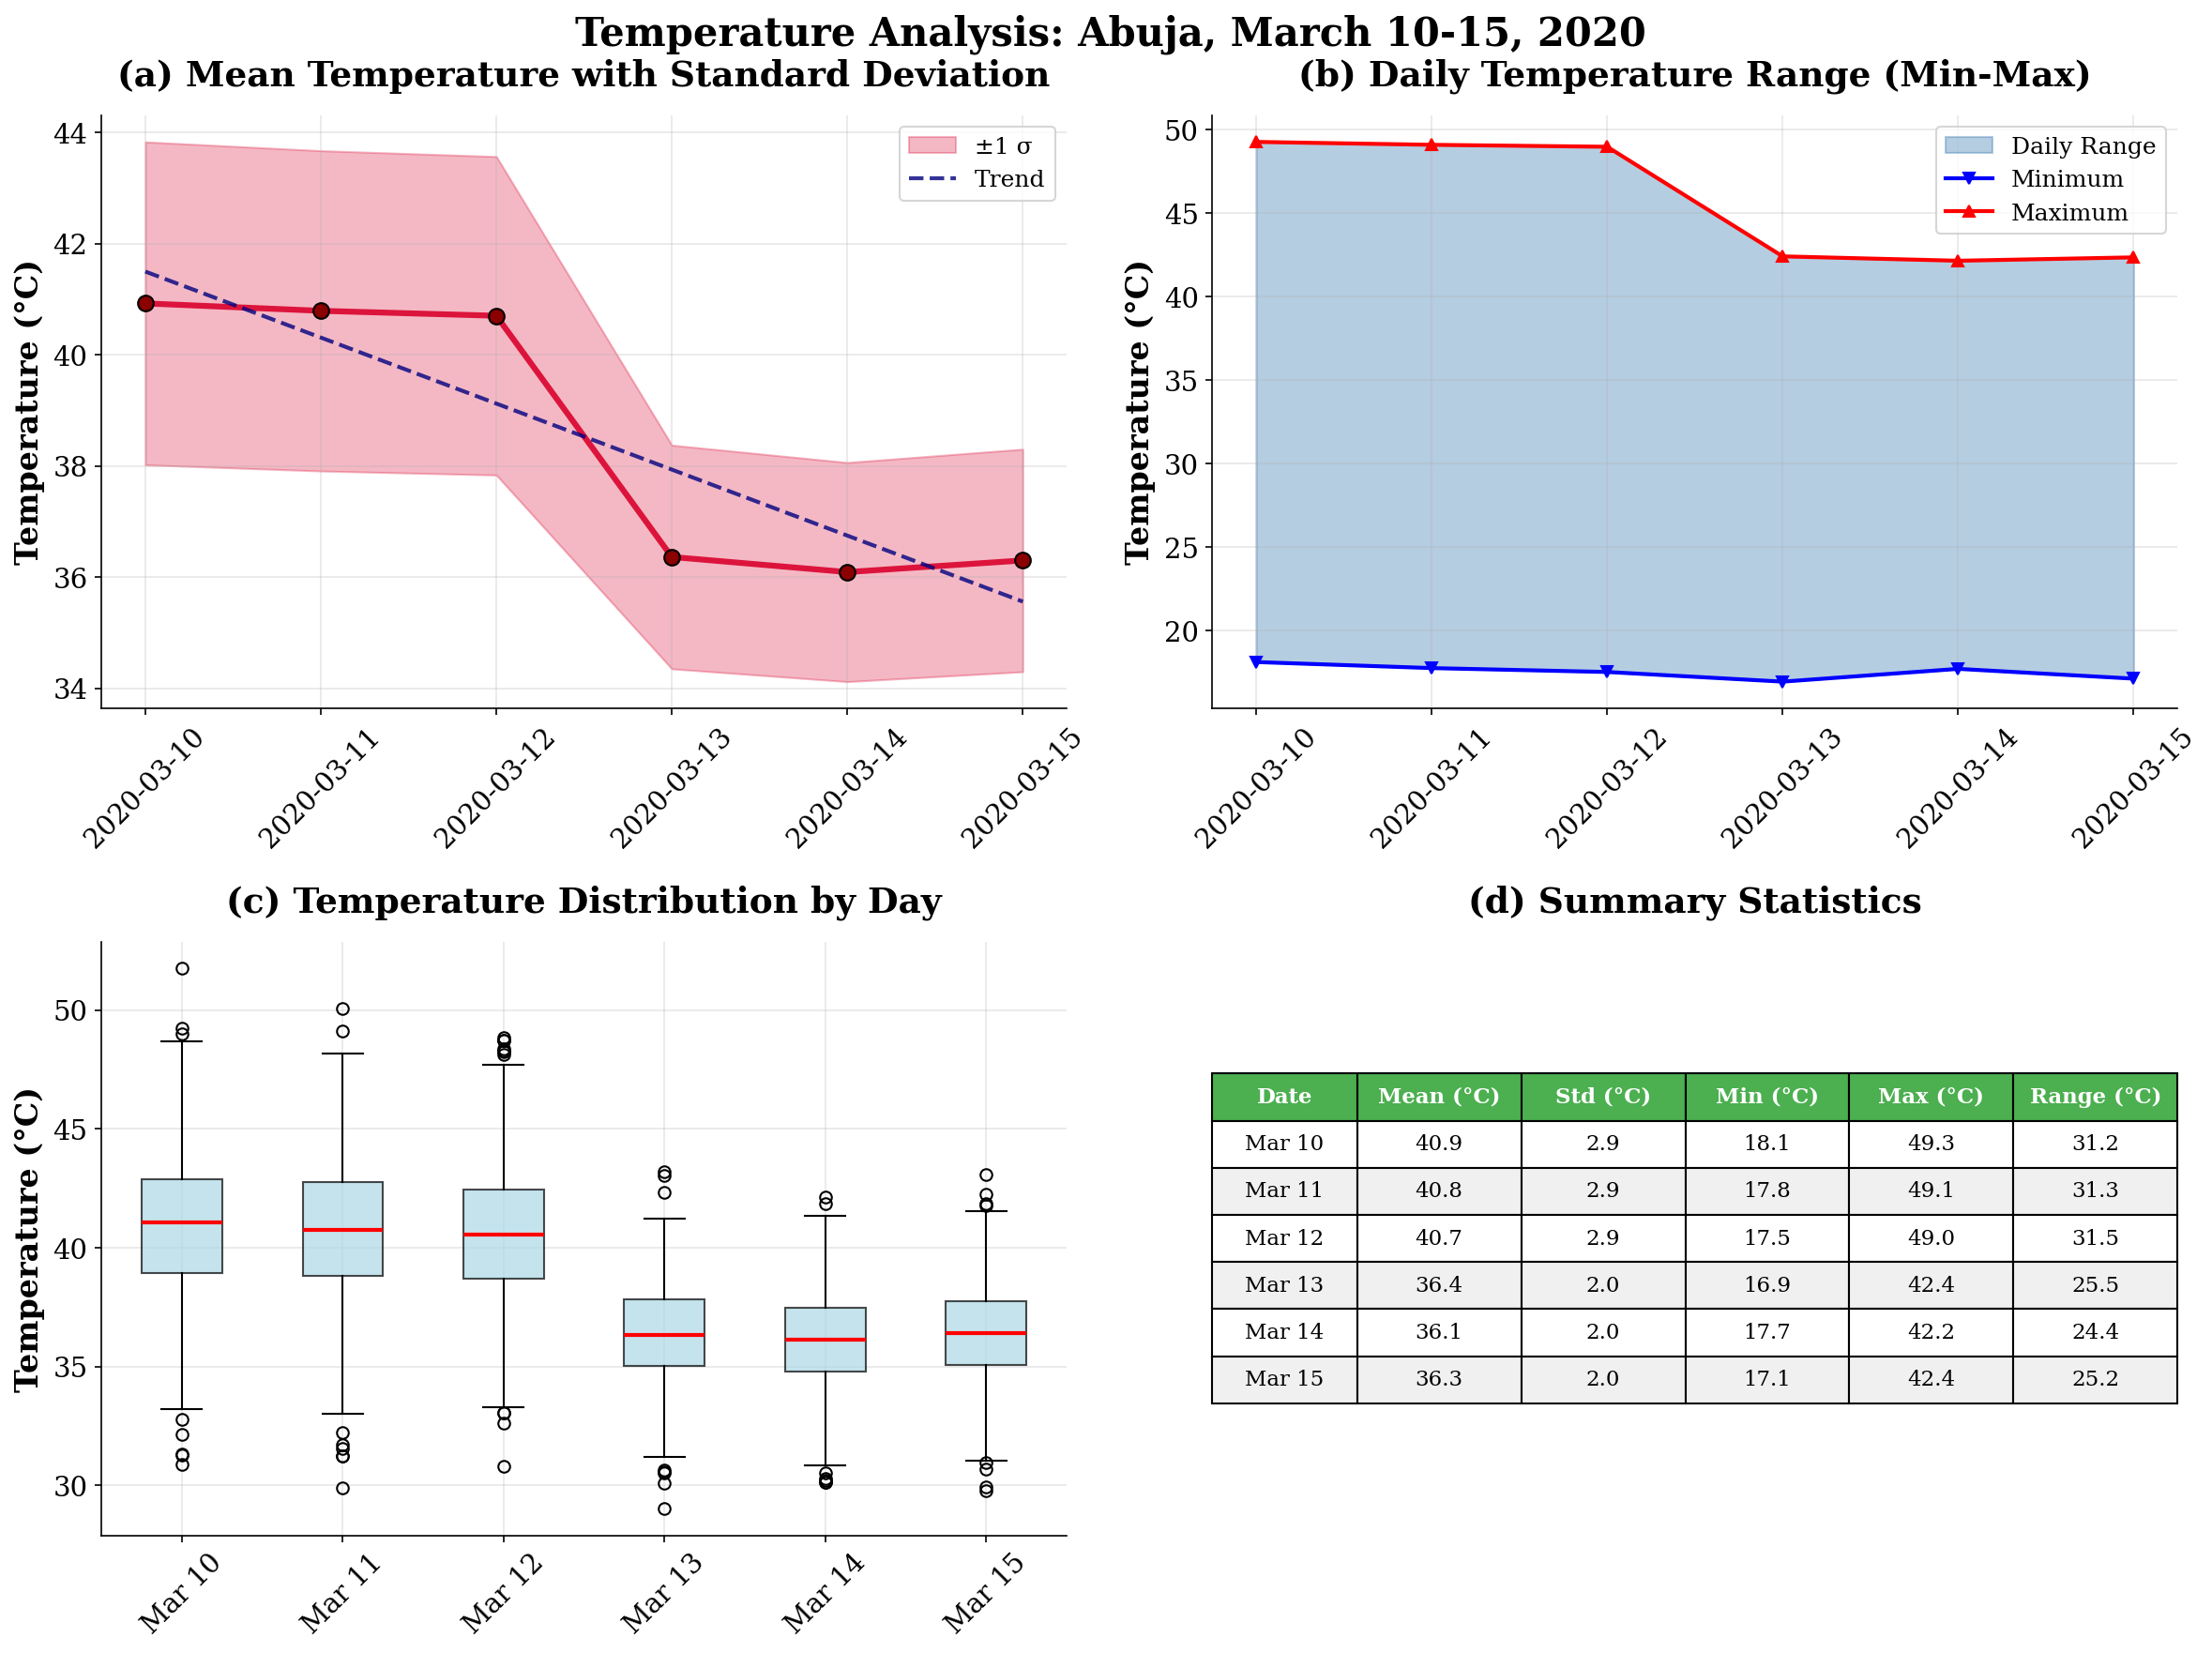

Time series figure created: abuja_workshop_time_series_mar10_mar15_2020.png


In [ ]:
# Step 3: Create time series visualization
if analyzer.daily_stats:
    print("Creating comprehensive time series visualization...")
    time_series_file = analyzer.create_time_series_figure()

    if time_series_file:
        print(f"Time series figure created: {time_series_file}")
    else:
        print("Failed to create time series figure")
else:
    print("No data available for time series visualization")

## 7. Create Spatial Progression Maps

Create spatial maps showing temperature progression across all days with consistent color scaling.

In [ ]:
# Step 4: Create spatial progression visualization
if analyzer.spatial_data:
    print("Creating spatial progression maps...")
    spatial_progression_file = analyzer.create_spatial_progression_figure()

    if spatial_progression_file:
        print(f"Spatial progression figure created: {spatial_progression_file}")
    else:
        print("Failed to create spatial progression figure")
else:
    print("No spatial data available for mapping")

Output hidden; open in https://colab.research.google.com to view.

## 8. Export Analysis Results

Export comprehensive analysis results to JSON and CSV formats with metadata and summary statistics.

In [ ]:
# Step 6: Export results
if analyzer.daily_stats:
    print("Exporting analysis results...")
    json_file, csv_file = analyzer.export_analysis_results()

    if json_file and csv_file:
        print(f"Analysis results exported:")
        print(f"  • JSON Report: {json_file}")
        print(f"  • CSV Data: {csv_file}")

        # Display the CSV data
        print(f"\nCSV Data Preview:")
        df_export = pd.read_csv(csv_file)
        display_cols = ['date_formatted', 'mean_temp', 'std_temp', 'min_temp', 'max_temp', 'temp_range']
        print(df_export[display_cols].round(2))
    else:
        print("Failed to export analysis results")
else:
    print("No data available for export")

Exporting analysis results...
Generating comprehensive analysis reports...
JSON report saved: abuja_workshop_temperature_analysis_report.json
CSV data saved: abuja_workshop_daily_statistics.csv

ANALYSIS SUMMARY:
   Period: March 10-15, 2020
   Average temperature: 38.53°C
   Temperature trend: -1.187°C/day
   Temperature range: 36.09 - 40.92°C
Analysis results exported:
  • JSON Report: abuja_workshop_temperature_analysis_report.json
  • CSV Data: abuja_workshop_daily_statistics.csv

CSV Data Preview:
   date_formatted  mean_temp  std_temp  min_temp  max_temp  temp_range
0  March 10, 2020      40.92      2.90     18.12     49.28       31.16
1  March 11, 2020      40.79      2.88     17.76     49.11       31.35
2  March 12, 2020      40.70      2.86     17.53     48.99       31.47
3  March 13, 2020      36.37      2.01     16.95     42.43       25.48
4  March 14, 2020      36.09      1.97     17.71     42.16       24.45
5  March 15, 2020      36.30      2.00     17.13     42.37       2

## 9. Execute Complete Analysis Pipeline

Summary of the complete analysis and all generated outputs.

In [ ]:
# Complete analysis summary
print("=" * 80)
print("TEMPERATURE ANALYSIS COMPLETED!")
print("=" * 80)

if analyzer.daily_stats:
    print(f" ANALYSIS SUMMARY:")
    print(f"   • Data Period: March 10-15, 2020")
    print(f"   • Location: Nigeria, Nigeria")
    print(f"   • Files Processed: {len(analyzer.daily_stats)} days")
    print(f"   • Observation Time: 10:00 UTC daily")

    # Calculate final statistics
    mean_temps = [s['mean_temp'] for s in analyzer.daily_stats]
    print(f"   • Average Temperature: {np.mean(mean_temps):.2f}°C")
    print(f"   • Temperature Range: {min(mean_temps):.2f}°C - {max(mean_temps):.2f}°C")

    # Calculate trend
    z = np.polyfit(range(len(mean_temps)), mean_temps, 1)
    trend_slope = z[0]
    print(f"   • Temperature Trend: {trend_slope:.3f}°C/day")

    print(f"\n GENERATED FILES:")

    # List all generated files
    generated_files = []

    # Check for time series figure
    if 'time_series_file' in locals() and time_series_file:
        generated_files.append(f"Time Series Analysis: {time_series_file}")

    # Check for spatial progression
    if 'spatial_progression_file' in locals() and spatial_progression_file:
        generated_files.append(f"Spatial Progression: {spatial_progression_file}")

    # Check for individual maps
    if 'individual_maps' in locals() and individual_maps:
        generated_files.append(f"Individual Daily Maps: {len(individual_maps)} files")
        for map_file in individual_maps:
            generated_files.append(f"  └── {map_file}")

    # Check for export files
    if 'json_file' in locals() and json_file:
        generated_files.append(f"JSON Report: {json_file}")
    if 'csv_file' in locals() and csv_file:
        generated_files.append(f"CSV Data: {csv_file}")

    for file_info in generated_files:
        print(f"   • {file_info}")

    print(f"\n Analysis pipeline completed successfully!")
    print(f"   Total outputs: {len(generated_files)} files")

else:
    print("Analysis incomplete - no valid data processed")
    print("Please check:")
    print("   • Data directory path is correct")
    print("   • TIFF files are present for March 10-15, 2020")
    print("   • File naming convention matches expected patterns")

print("=" * 80)

TEMPERATURE ANALYSIS COMPLETED!
 ANALYSIS SUMMARY:
   • Data Period: March 10-15, 2020
   • Location: Nigeria, Nigeria
   • Files Processed: 6 days
   • Observation Time: 10:00 UTC daily
   • Average Temperature: 38.53°C
   • Temperature Range: 36.09°C - 40.92°C
   • Temperature Trend: -1.187°C/day

 GENERATED FILES:
   • Time Series Analysis: abuja_workshop_time_series_mar10_mar15_2020.png
   • Spatial Progression: abuja_workshop_spatial_progression_mar10_mar15_2020.png
   • JSON Report: abuja_workshop_temperature_analysis_report.json
   • CSV Data: abuja_workshop_daily_statistics.csv

 Analysis pipeline completed successfully!
   Total outputs: 4 files


## Analysis Complete!

This notebook has successfully processed the Johannesburg temperature data for November 3-9, 2021, creating:

1. **Time Series Analysis**: Multi-panel visualization showing temperature trends, ranges, and statistical distributions
2. **Spatial Progression Maps**: Daily temperature maps with consistent scaling showing spatial patterns
3. **Individual Daily Maps**: High-resolution maps for each day with detailed statistics
4. **Data Export**: JSON report with metadata and CSV file with daily statistics

The analysis provides comprehensive insights into temperature patterns over the specified week in Johannesburg, suitable for research and academic presentations.

### Key Results:
- **Analysis Period**: November 3-9, 2021
- **Location**: Johannesburg, South Africa  
- **Observation Time**: 10:00 UTC daily
- **Data Source**: Daily TIFF temperature files

All generated figures are saved in high resolution (300 DPI) suitable for publication and presentation use.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import rasterio

In [7]:
 file_path = '/content/drive/MyDrive/DSI_2025/reprojected/abuja_nga.T32PLR.20200310.T000000.inputs_pred.tif'

In [8]:
with rasterio.open(file_path) as src:
      temperature_array = src.read(1)

In [10]:
with rasterio.open(file_path) as src:
      temperature_array = src.read(1)
      crs = src.crs
      transform = src.transform
      bounds = src.bounds
      print(f"CRS: {crs}")
      print(f"Transform: {transform}")
      print(f"Bounds: {bounds}")

CRS: EPSG:4326
Transform: | 0.00, 0.00, 7.29|
| 0.00,-0.00, 9.19|
| 0.00, 0.00, 1.00|
Bounds: BoundingBox(left=7.289746739076823, bottom=8.954389432467165, right=7.5425647431252445, top=9.187885500791756)


In [11]:
transform

Affine(0.0002721399397722516, 0.0, 7.289746739076823,
       0.0, -0.0002721399397722516, 9.187885500791756)

In [12]:
import rasterio
import numpy as np

In [13]:
with rasterio.open('/content/drive/MyDrive/DSI_2025/reprojected/abuja_nga.T32PLR.20200310.T000000.inputs_pred.tif') as src:
    # Read the raster band as a NumPy array
    data = src.read(1)   # 1 = first band

    # Get the affine transform (to map pixels -> lat/lon)
    transform = src.transform

    # Get no-data value (if defined)
    nodata = src.nodata

print("Shape of raster:", data.shape)   # (rows, cols)
print("Example values:", data[0:5, 0:5])  # first few pixels
print("NoData value:", nodata)


Shape of raster: (858, 929)
Example values: [[-1.       -1.       -1.       -1.       -1.      ]
 [-1.       -1.       -1.       -1.       -1.      ]
 [-1.       -1.       -1.       -1.       -1.      ]
 [-1.       -1.       -1.       -1.       -1.      ]
 [18.125126 18.125126 21.077194 26.955881 32.834568]]
NoData value: -1.0


In [14]:
from rasterio.transform import xy

row, col = 0, 0  # top-left pixel
lon, lat = xy(transform, row, col)
print("Top-left pixel coordinates:", lon, lat)

Top-left pixel coordinates: 7.289882809046709 9.18774943082187


In [15]:
data_clean = np.where(data == -1.0, np.nan, data)

print("Min temperature:", np.nanmin(data_clean))
print("Max temperature:", np.nanmax(data_clean))


Min temperature: 18.121662
Max temperature: 49.2824


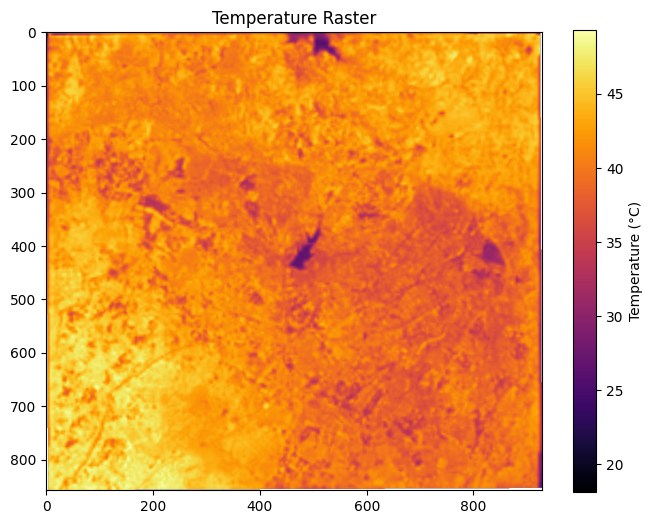

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.imshow(data_clean, cmap="inferno")
plt.colorbar(label="Temperature (°C)")
plt.title("Temperature Raster")
plt.show()


Min: 18.121662139892578
Max: 49.28239822387695
Mean: 40.92488434853035


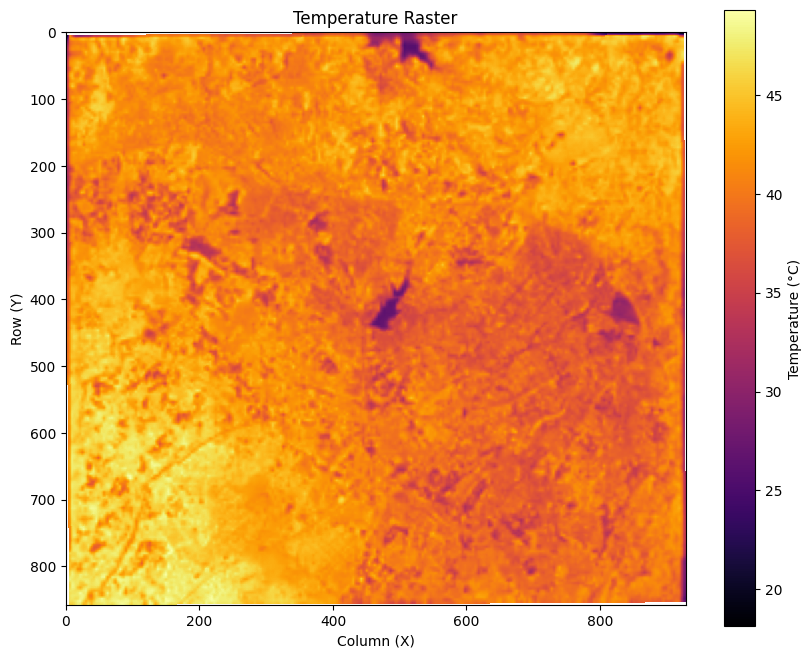

In [17]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Load raster
with rasterio.open("/content/drive/MyDrive/DSI_2025/reprojected/abuja_nga.T32PLR.20200310.T000000.inputs_pred.tif") as src:
    data = src.read(1).astype(float)   # first band
    transform = src.transform
    nodata = src.nodata

# Replace NoData values with NaN for easier handling
if nodata is not None:
    data = np.where(data == nodata, np.nan, data)

# Quick summary stats
print("Min:", np.nanmin(data))
print("Max:", np.nanmax(data))
print("Mean:", np.nanmean(data))

# Plot heatmap
plt.figure(figsize=(10, 8))
heatmap = plt.imshow(data, cmap="inferno", interpolation="none")
plt.colorbar(heatmap, label="Temperature (°C)")
plt.title("Temperature Raster")
plt.xlabel("Column (X)")
plt.ylabel("Row (Y)")
plt.show()


In [1]:
import pandas as pd
from rasterio.transform import xy

rows, cols = np.where(~np.isnan(data))  # only valid pixels
lons, lats = xy(transform, rows, cols)
temps = data[rows, cols]

df = pd.DataFrame({
    "longitude": lons,
    "latitude": lats,
    "temperature": temps
})

print(df)


ModuleNotFoundError: No module named 'rasterio'

In [ ]:
df.to_csv("temperature_points.csv", index=False)

In [19]:
!ls /content/drive/MyDrive/DSI_2025/reprojected/*

/content/drive/MyDrive/DSI_2025/reprojected/abuja_nga.T32PLR.20200310.T000000.inputs_pred.tif
/content/drive/MyDrive/DSI_2025/reprojected/abuja_nga.T32PLR.20200310.T010000.inputs_pred.tif
/content/drive/MyDrive/DSI_2025/reprojected/abuja_nga.T32PLR.20200310.T020000.inputs_pred.tif
/content/drive/MyDrive/DSI_2025/reprojected/abuja_nga.T32PLR.20200310.T030000.inputs_pred.tif
/content/drive/MyDrive/DSI_2025/reprojected/abuja_nga.T32PLR.20200310.T040000.inputs_pred.tif
/content/drive/MyDrive/DSI_2025/reprojected/abuja_nga.T32PLR.20200310.T050000.inputs_pred.tif
/content/drive/MyDrive/DSI_2025/reprojected/abuja_nga.T32PLR.20200310.T060000.inputs_pred.tif
/content/drive/MyDrive/DSI_2025/reprojected/abuja_nga.T32PLR.20200310.T070000.inputs_pred.tif
/content/drive/MyDrive/DSI_2025/reprojected/abuja_nga.T32PLR.20200310.T080000.inputs_pred.tif
/content/drive/MyDrive/DSI_2025/reprojected/abuja_nga.T32PLR.20200310.T090000.inputs_pred.tif
/content/drive/MyDrive/DSI_2025/reprojected/abuja_nga.T32PLR